## Imports

In [1]:
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image, ImageDraw
import numpy as np
import cv2

from numpy.ctypeslib import ndpointer
import ctypes, ctypes.util
import sys, platform
import shutil

import threading
import logging
import time

from IPython import display

from thread_camera import WebcamVideoStream
from utils import load_image_with_alpha, overlay_alpha
from utils import draw_text, draw_multiline_text, draw_skeleton

print('cv2.__version__:', cv2.__version__)  # 4.1.2 recommended

logging.basicConfig(level=logging.DEBUG, format='(%(threadName)-10s) %(message)s')

ctypes.util.find_library("libSystem.B.dylib")
print('shutil.which("libSystem.B.dylib"):', shutil.which("libSystem.B.dylib"))
print('ctypes.CDLL("libSystem.B.dylib")._name:', ctypes.CDLL("libSystem.B.dylib")._name)
print('ctypes.__version__:', ctypes.__version__)
print('platform.mac_ver():', platform.mac_ver())

(MainThread) Loaded backend module://ipykernel.pylab.backend_inline version unknown.


cv2.__version__: 4.1.2
shutil.which("libSystem.B.dylib"): None
ctypes.CDLL("libSystem.B.dylib")._name: libSystem.B.dylib
ctypes.__version__: 1.1.0
platform.mac_ver(): ('10.16', ('', '', ''), 'x86_64')


## Initialization

In [2]:
%tb

# https://solarianprogrammer.com/2019/07/18/python-using-c-cpp-libraries-ctypes/
mylib_path = ctypes.util.find_library("full_cpu")
if not mylib_path:
    print("Unable to find the specified library.")
    sys.exit()

try:
    jesture_lib = ctypes.CDLL(mylib_path)
except OSError:
    print("Unable to load the system C library")
    sys.exit()

No traceback available to show.


In [3]:
create_full_cpu = jesture_lib.CreateFullCpu
create_full_cpu.argtypes = [ctypes.c_int]
create_full_cpu.restype = ctypes.POINTER(ctypes.c_int)

run_full_cpu = jesture_lib.RunFullCpu
run_full_cpu.argtypes = [ctypes.POINTER(ctypes.c_int)]
run_full_cpu.restype = None

stop_full_cpu = jesture_lib.StopFullCpu
stop_full_cpu.argtypes = [ctypes.POINTER(ctypes.c_int)]
stop_full_cpu.restype = None

dispose_full_cpu = jesture_lib.DisposeFullCpu
dispose_full_cpu.argtypes = [ctypes.POINTER(ctypes.c_int)]
dispose_full_cpu.restype = None

# -------------- HANDS --------------

# gestures

get_dynamic_gesture = jesture_lib.GetCurrentDynamicGesture
get_dynamic_gesture.argtypes = [ctypes.POINTER(ctypes.c_int)]
get_dynamic_gesture.restype = ctypes.c_char_p

get_dynamic_gesture_idx = jesture_lib.GetCurrentDynamicGestureIdx
get_dynamic_gesture_idx.argtypes = [ctypes.POINTER(ctypes.c_int)]
get_dynamic_gesture_idx.restype = ctypes.c_int

get_static_left_gesture = jesture_lib.GetCurrentStaticLeftGesture
get_static_left_gesture.argtypes = [ctypes.POINTER(ctypes.c_int)]
get_static_left_gesture.restype = ctypes.c_char_p

get_static_right_gesture = jesture_lib.GetCurrentStaticRightGesture
get_static_right_gesture.argtypes = [ctypes.POINTER(ctypes.c_int)]
get_static_right_gesture.restype = ctypes.c_char_p

# absolute keypoints

get_hand_left_keypoints = jesture_lib.GetCurrentHandLeftKeypoints
get_hand_left_keypoints.argtypes = [ctypes.POINTER(ctypes.c_int)]
get_hand_left_keypoints.restype = ndpointer(dtype=ctypes.c_double, shape=(63,))

get_hand_right_keypoints = jesture_lib.GetCurrentHandRightKeypoints
get_hand_right_keypoints.argtypes = [ctypes.POINTER(ctypes.c_int)]
get_hand_right_keypoints.restype = ndpointer(dtype=ctypes.c_double, shape=(63,))

# scaled screen size-independent keypoints

get_scaled_left_keypoints = jesture_lib.GetCurrentScaledLeftKeypoints
get_scaled_left_keypoints.argtypes = [ctypes.POINTER(ctypes.c_int)]
get_scaled_left_keypoints.restype = ndpointer(dtype=ctypes.c_double, shape=(63,))

get_scaled_right_keypoints = jesture_lib.GetCurrentScaledRightKeypoints
get_scaled_right_keypoints.argtypes = [ctypes.POINTER(ctypes.c_int)]
get_scaled_right_keypoints.restype = ndpointer(dtype=ctypes.c_double, shape=(63,))

## Image routines

(MainThread) STREAM b'IHDR' 16 13
(MainThread) STREAM b'IDAT' 41 8192
(MainThread) findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
(MainThread) findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
(MainThread) findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
(MainThread) findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font 'DejaV

(MainThread) findfont: score(<Font '.SF Compact Rounded' (SFCompactRounded-Heavy.otf) normal normal heavy normal>) = 10.43
(MainThread) findfont: score(<Font 'Myanmar Sangam MN' (Myanmar Sangam MN.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Semibold.otf) normal normal semibold condensed>) = 10.44
(MainThread) findfont: score(<Font 'System Font' (SFNSDisplay-MediumItalic.otf) italic normal medium normal>) = 11.145
(MainThread) findfont: score(<Font 'System Font' (SFNSDisplay-BlackItalic.otf) italic normal black normal>) = 11.525
(MainThread) findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) norma

(MainThread) findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Gurmukhi Sangam MN' (Gurmukhi Sangam MN.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W9.ttc) normal normal 700 normal>) = 10.335
(MainThread) findfont: score(<Font 'STIXIntegralsSm' (STIXIntSmBol.otf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font 'Skia' (Skia.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'SignPainter' (SignPainter.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Gurmukhi MT' (Gurmukhi.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal bold normal>) = 11.335
(MainThread) findfont: score(<Font '.SF NS Symbols' (SFNSSymbols-Thin.otf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font '.SF Compact 

(MainThread) findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.otf) italic normal bold normal>) = 11.335
(MainThread) findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Regular.otf) normal normal regular normal>) = 10.05
(MainThread) findfont: score(<Font '.Helvetica Neue DeskInterface' (HelveticaNeueDeskInterface.ttc) normal normal regular normal>) = 10.05
(MainThread) findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Light.otf) normal normal light condensed>) = 10.44
(MainThread) findfont: score(<Font '.Aqua Kana' (AquaKana.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.otf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font 'Bodoni 72 Smallcaps' (Bodoni 72 Smallcaps Book.ttf) normal normal book normal>) = 10.05
(MainThread) findfont: score(<Font 'Apple Braille' (Apple

Removing 250 pixels from up and down borders
Original image size: (1920, 580)
Target size: (192, 58)


(MainThread) findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'DIN Alternate' (DIN Alternate Bold.ttf) normal normal bold normal>) = 10.335
(MainThread) findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'Farisi' (Farisi.ttf) normal normal regular normal>) = 10.05
(MainThread) findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font '.SF NS Symbols' (SFNSSymbols-Medium.otf) normal normal medium normal>) = 10.145
(MainThread) findfont: score(<Font 'System Font' (SFNSText.ttf) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font '.SF Compact Text' (SFCompactText-Regular.otf) normal normal regular normal>) = 10.05
(MainThread) findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.05
(MainThread) findfont: score(<Font 'New P

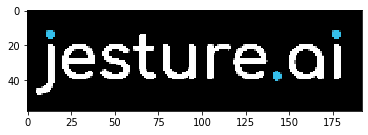

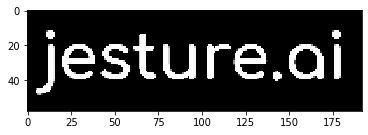

In [4]:
design_root = '/Users/izakharkin/Desktop/deepjest/_design'
logo_path = f'{design_root}/wix/jesture_ai_logo_comfortaa/jesture_logo_comfortaa-removebg.png'

logo_img, logo_alpha = load_image_with_alpha(logo_path, remove_borders=True)

plt.imshow(logo_img);
plt.show();
plt.imshow(logo_alpha, cmap='gray');
plt.show();

## Demo

In [5]:
def daemon():
    logging.debug('Starting')
    run_full_cpu(instance)
    logging.debug('Exiting')

In [6]:
instance = create_full_cpu(1)
print(instance)
d = threading.Thread(name='daemon', target=daemon)
d.setDaemon(True)
d.start()

(daemon    ) Starting


In [7]:
get_scaled_left_keypoints(instance).reshape(21, 3)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [8]:

# stop_full_cpu(instance)


In [9]:
def process_hand_keypoints(raw_keypoints, mirror=True, img_width=640):
    keypoints = raw_keypoints.reshape(21, 3).copy()
    if mirror:
        keypoints[:,0] = img_width - keypoints[:,0]
    return keypoints

In [10]:
name = 'JestureSDK: Python Demo'
width, height = (640, 480)
# cv2.namedWindow(name, cv2.WINDOW_NORMAL)
# cv2.resizeWindow(name, (width, height))
# cv2.startWindowThread()

idx_to_gesture = {1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five',
                  6: 'fist', 7: 'piece', 8: 'love', 9: 'ok', 0: 'horns'}
help_textlist = [f'{k}: {v}' for k, v in idx_to_gesture.items()]
logo_loc = (10, 10)
help_loc = (10, height//2)
notify_loc = (width-10, height-50)

In [11]:
cap = WebcamVideoStream(cam_id=1, width=width, height=height)
cap.start()

selfie_mode = True
i = 0
while(True):
    if cap.frame is None:
        continue
        
    frame = cap.frame[:,::-1,:] if selfie_mode else cap.frame  # TODO: read frames from dylib
    frame = overlay_alpha(logo_img[:,:,::-1], logo_alpha, frame, loc=logo_loc, alpha=1.0)
    
    left_keypoints = process_hand_keypoints(get_hand_left_keypoints(instance))
    right_keypoints = process_hand_keypoints(get_hand_right_keypoints(instance))
    left_scaled_keypoints = process_hand_keypoints(get_scaled_left_keypoints(instance))
    right_scaled_keypoints = process_hand_keypoints(get_scaled_right_keypoints(instance))
    
    frame = draw_skeleton(frame, left_keypoints)
    frame = draw_skeleton(frame, right_keypoints)
    frame = draw_skeleton(frame, left_scaled_keypoints)
    frame = draw_skeleton(frame, right_scaled_keypoints)
    
    frame = Image.fromarray(frame.get())
    draw = ImageDraw.Draw(frame, "RGBA")
    draw.rectangle(((10, height//6), (160, height-height//6)), fill=(0, 0, 0, 127))
    draw.rectangle(((10, height//6), (160, height-height//6)), outline=(235, 190, 63, 127))
    frame = np.array(frame).astype(np.uint8)
    
    frame = draw_multiline_text(frame, help_textlist, xloc=10, color=(255,255,255))
    
    cv2.imshow(name, frame)
    
    c = cv2.waitKey(1) % 256
    if c == ord('q'):
        stop_full_cpu(instance)
        break
    for k,v in idx_to_gesture.items():
        if c == ord(str(k)):
            notify_text = f"pressed {k}:{v}"
            print(notify_text)
            frame = draw_text(frame, notify_text, org=notify_loc, 
                              color=(0,0,0), fontScale=0.75)
        
    i += 1

d.join()
cap.stop()
stop_full_cpu(instance)
dispose_full_cpu(instance)
cv2.destroyAllWindows()

(daemon    ) Exiting
(MainThread) [WebcamVideoStream] Stopping...
(thread_camera_python) [WebcamVideoStream] Frame loop finished.
(thread_camera_python) [WebcamVideoStream] Capture released.
(MainThread) [WebcamVideoStream] Camera thread joined.


In [ ]:
d.join()
cap.stop()
stop_full_cpu(instance)
dispose_full_cpu(instance)
cv2.destroyAllWindows()

(MainThread) [WebcamVideoStream] Stopping...
